This notebook is divided into 6 parts:
- Background
- Prerequisites
- Experiment Design
- Running Experiment
- Result to Decision
- Post-Launch Monitoring

import useful librairies:

In [1]:
import pandas as pd
import datetime
from random import sample
from random import seed
from scipy.stats import beta
import numpy as np

# Background
Imagine that a webpage was developed for an ecommerce platform, and we want to test the effect of the new page on a given metric.

# Prerequisites
Before running the experiemnts the following needs to be clarified:
- Objective and key metrics
- Product Variants
- Randomization units

## Objective & Key Metrics:
Key metrics are defined. We assume that we want to see the consequence on the conversion rate:
- purchase conversion = nb. converted users / nb. exposed users

The exposure and conversion data is defined below:
- Exposure: A user is exposed to their respective variant (webpage)
- Conversion: A user purchases a product within 7 days after being exposed to the variant (webpage).

## Randomization unit: 
Assumption: There are enough users (/total number of observations) in our experiement.

## Product Variants:
- Assumption: The number of users in control and treatment groups are similar

# Experiment Design

## Target population:
Who is the target population? 

Do we want to target all the users or a specific segment of users? 

To answer this question, it is possible to analyze the user's journey (funnel). 

For example, we could select only the users who have the intention to buy products and who started checking out.



## Practical significance boundary:
Practical significance boundary, a.k.a. effect size: for example, we could agree that an increase of 2% in average conversion rate is practically significant. 

As a result, we could launch the change to production.

In [2]:
significant_lift = 2

## Power of the test:
Probability of True Positive: detecting a given effect size when the effect is real. Probability = 1 - Beta.

Industry standard: Power = 80%

In [3]:
power = 0.8

## Significance Level (alpha):
Probability of a False Positive (Type II error) : Mistakenly concluding that an effect is real (when it's actually due to chance). Probability = alpha

Industry standard: Significance level = 5% (=0.05)

In [4]:
alpha = 0.05

## Sample size:
What is the sample size of the experiment? How many user should be allocated randomly in each group?

Sample size = (16*sigma^2) / delta^2
with:
- sigma: the standard deviation of the population
- delta: difference between treatment and control

Assume sigma is equal to 20. Then, the sample size is 16*20^2 / 2^2 = 1600 unique users in each variant. 

If there are 3 variants, we need a total population of 4800 unique users for 3 variants.

If a smaller effect size (USD 1/user) or a smaller significance level (alpha=2.5%) has to be detected, then the sample size has to be increased.

## Duration: 
For the experiment, the data collected represent 3 weeks of exposure / conversion data as defined below:
- Exposure: A user is exposed to their respective variant (webpage)
- Conversion: A user purchases a product within 7 days after being exposed to the variant (webpage).

A number of elements can affect the duration of an experiment:
- latency
- time required to get the data
- seasonality
- primacy and novelty effects

### Ramp-up plan:
Defining a ramp-up plan allows to have no bugs and handle traffic without latency.
- Expose to a small population
- Gradually increase percentage

Example: 
- day 1: 5% of the treatment group
- day 2: increase to 10% of the treatment group
- day 3: increase to 33% of the tratment group

Assuming there are 2000 users / day entering checkout while purchasing products, then the experiment needs to run for a minimum of 4 days:

- day 1: 5%
- day 2: 10%
- day 1: 33% 
- day 1: 33% 

### Day of week effect:
People behave differently during an entire week. As a result, the experiment should run for at least an entire week to capture this effect.

### Seasonality
Data during holidays cannot be used for analysis and the experiment must run longer

### Primacy or novelty effects:
- Users respond to changes differently, and the duration of the experiment must be chosen carefully


# Running Experiment

## Assumptions:
- No interaction effects between units in control / treatment.

## Sanity check:
- Number of users assigned to groups is respected and random
- Consistency for each variant: Latency when using the product is similar, as it could affect the results

## Data collection
The data was collected and added to a CSV file. Each row is logged when a user is exposed to a variant:

In [5]:
df = pd.read_csv('data_modified.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
len(df)

294478

In [7]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.122485
std,91210.823776,0.327845
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


Columns definition:
- timestamp: time of exposure
- group: bucket (control, treatment)
- landing_page: variants (new_page, old_page)
- converted: converted (1) or not (0)

# Result to Decision
The results are checked and interpreted to make decisions

## Sanity checks
- If passed, continue with analysis
- If failed, look into root cause, discard the results or correct if possible. 

In [8]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f') # start of the data collection
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f') #end of the data collection
data_duration = (end_time - start_time).days #number of days of the experiment

t = df['user_id'].nunique()
a = int(df[df['group'] == 'treatment'].shape[0]) # Number of subjects in treatment group
b = int(df[df['group'] == 'control'].shape[0]) # Number of subjects in control group A

print(f"Nb. of unique user_id in experiment: {t}")
print(f"Nb. of total entries in experiment: {df.shape[0]}")
print(f"Nb. of users in treatment group: {a}")
print(f"Nb. users in control group: {b}")
print(f"Duration: {data_duration} days.")

Nb. of unique user_id in experiment: 290584
Nb. of total entries in experiment: 294478
Nb. of users in treatment group: 147276
Nb. users in control group: 147202
Duration: 21 days.


### Data cleaning

In [9]:
counter = df['user_id'].value_counts()
mistake = (counter > 1).value_counts()
print(mistake)
print(f"{mistake[1]} user_ids have been exposed to an old and new page. Those data should be removed as they do not represent a big part of the data collected")

False    286690
True       3894
Name: user_id, dtype: int64
3894 user_ids have been exposed to an old and new page. Those data should be removed as they do not represent a big part of the data collected


In [10]:
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])

### Data engineering

In [11]:
#Add week column:
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])
number_of_week = df['week'].value_counts()
df.head()

,user_id,timestamp,group,landing_page,converted,week
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,3
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,3


In [12]:
print(number_of_week)

2    91380
3    91056
1    83745
4    20509
Name: week, dtype: int64


## Defining Variables

In [13]:
# Variables that fully define the A/B test results

NUM_WEEKS = number_of_week.shape[0]
experiment_data = df[df['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group'] == 'control']
treatment = experiment_data[experiment_data['group'] == 'treatment']

a = treatment['converted'].count() # Number of subjects in treatment group
b = control['converted'].count() # Number of subjects in control group
t = a+b #total nummber of subjects in the experiment

a_yes = treatment['converted'].sum() # Yes count in treatment group
b_yes = control['converted'].sum() # Yes count in control group

#Compute remaining A/B test results
t_yes = a_yes + b_yes # Total yes count
t_no = t - t_yes # Total no count
a_yes_pc = 100* a_yes / a # Yes percentage in treatment group
b_yes_pc = 100* b_yes / b # Yes percentage in control group

# A/B testing Statistic: Yes percentage change difference (A-B)
ab_yes_pc = ((b_yes_pc - a_yes_pc) / abs(b_yes_pc))*100

print(f"- Nb. of unique user_id in experiment: {t}")
print(f"- Nb. of total entries in experiment: {df.shape[0]}")
if t != df.shape[0]:
    print("WARNING!: The number of unique user_id and total entries in the experiment is different!")

print(f"- Nb. of users in treatment group: {a}")
print(f"- Nb. users in control group: {b}")
print(f"- Duration of the Experiment: {data_duration} days.")

print(f'- Observed Yes rate for A (treatment conversion rate): {round(a_yes_pc,3)}% \n- Observed Yes rate for B (control conversion rate): {round(b_yes_pc,3)}%, \n- A-B (Lift): {round(ab_yes_pc, 3)}%, \n- Total counts: Yes: {t_yes}, No: {t_no}')

- Nb. of unique user_id in experiment: 286690
- Nb. of total entries in experiment: 286690
- Nb. of users in treatment group: 143397
- Nb. users in control group: 143293
- Duration of the Experiment: 21 days.
- Observed Yes rate for A (treatment conversion rate): 12.44% 
- Observed Yes rate for B (control conversion rate): 12.017%, 
- A-B (Lift): -3.514%, 
- Total counts: Yes: 35058, No: 251632


## Doing p Permutations

In [14]:
seed(2) # For reproducible results

bag = [1]*t_yes + [0]*t_no #S1 : create a bag with all the data

p = 1000 # number of permutations
perm_res = [0]*p # list for permutation results

for i in range (p):
    bag = sample(bag, k=len(bag)) # S2: Shuffle the bag
    a_rs = bag[:a]                # S3: Random sample A
    b_rs = bag[a:]                # S4: Random sample B
    # Step 5: Compute the test statistic
    perm_res[i] = 100*sum(a_rs)/a - 100*sum(b_rs)/b

# Print representation of the Null hypothesis and can be used to compute the p-value
# n = 5
# for i in range(0, len(perm_res), n):
#     print(str(perm_res[i:i+n]).replace(",", "").replace(".0", ""))

Reminder about Powers and Errors:
- Power: Probability of detecting a give effect size when the effect is real (True Positive). 
- Type I error (False Negative): Mistakenly concluding that an effect is due to chance(when it's actually real). Probability = Beta
- Type II error (False Positive): Mistakenly concluding that an effect is real (when it's actually due to chance). Probability = Alpha

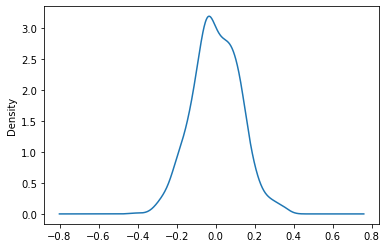

In [15]:
# Transform list to pandas series:
perm_res_s = pd.Series(perm_res)
#print(pd.pivot_table(perm_res_s.value_counts().reset_index(), values = 0, columns = "index").to_string(index=False))
#ax = perm_res_s.plot.hist(bins=100, alpha=1)
ax1= perm_res_s.plot.kde()

## Hypothesis tests

### Frequentist approach

In [16]:
# Two-way hypothesis test (Null: A = B, Alternative: A != B)
extreme_count = sum(perm_res_s.abs() >= abs(ab_yes_pc))
p_value = extreme_count / p

# One-way hypothesis test (Null: A <= B, Alternative: A > B)
pos_extreme_count = sum(perm_res_s >= ab_yes_pc)

print("Number of permutations:", p, 
    "\nTwo-way Hypothesis Test: (Null: A = B, Alternative: A != B)"
    "\nExtreme count          :", extreme_count,
    "\nExtreme ratio (p-value):", p_value,)
   #  "\nOne-way: Extreme count          :", pos_extreme_count,
   #  "\nOne-way: Extreme ratio (p-value):", pos_extreme_count / p)

Number of permutations: 1000 
Two-way Hypothesis Test: (Null: A = B, Alternative: A != B)
Extreme count          : 0 
Extreme ratio (p-value): 0.0


In [17]:
if p_value > alpha:
    print(f"The null hypothesis CANNOT be rejected! \nThe p-value is bigger than the significance level (0.05):\n ({p_value} > {alpha})")
else:
    print(f"The null hypothesis CAN be rejected! \nThe p-value = {round(p_value,10)} is smaller than the significance level (0.05):\n ({p_value} < {alpha})")

The null hypothesis CAN be rejected! 
The p-value = 0.0 is smaller than the significance level (0.05):
 (0.0 < 0.05)


### Bayesian approach
The baysian approach can provide a much better grasp of the result by providing a posterior distribution that can be compared with the distribution before the experiment started (prior). 

We can therefore output a result that is an actionable statement such as: "We can be X% confident that the lift is Y%"

The bayes theorem is intended to be used multiple times, each time gaining new evidence and update that an hypothesis is true. When Richard price introduced Bayes' Theorem, he made an analogy to a man coming out of a cave, who never seen the outside world before. He saw the Sun rise for the first time, and thoguht to himself: Is the sun rising a one-off event or does the Sun always do this? Every day after that, as the Sun rose again, he could get a little bit more confident that the way the world work.

Assumption:
In this example, we cannot access prior data, as a result the data of the first week is considered as the prior data, and the rest of the data as the posterior data.

Let's create the prior beta distribution from the first weeks of converstion data:

In [18]:
prior = df[(df['week'] == 1) & (df['group'] == 'control')]

Then, we take 10000 samples of purchase conversions rate

In [19]:
prior_means = []
for i in range(10000):
    prior_means.append(prior.sample(1000)['converted'].mean())

Feed the sample to model a Beta Distribution from sample means:

In [20]:
prior_alpha, prior_beta, _, _= beta.fit(prior_means, floc=0, fscale=1)

In [21]:
# Variables that fully define the A/B test results

NUM_WEEKS = number_of_week.shape[0]-1
experiment_data = df[(df['week'] > 1) & (df['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group'] == 'control']
treatment = experiment_data[experiment_data['group'] == 'treatment']

a = treatment['converted'].count() # Number of subjects in treatment group
b = control['converted'].count() # Number of subjects in control group
t = a+b #total nummber of subjects in the experiment

a_yes = treatment['converted'].sum() # Yes count in treatment group
a_no = treatment['converted'].count() - a_yes #No count in treatment group

b_yes = control['converted'].sum() # Yes count in control group
b_no = control['converted'].count() - b_yes # No count in control group

posterior_treatment = beta(prior_alpha + a_yes, prior_beta + a_no)
posterior_control = beta(prior_alpha + b_yes, prior_beta + b_no)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
# probability = np.mean(treatment_samples > control_samples)

#Compute remaining A/B test results
t_yes = a_yes + b_yes # Total yes count
t_no = t - t_yes # Total no count
a_yes_pc = 100* a_yes / a # Yes percentage in treatment group
b_yes_pc = 100* b_yes / b # Yes percentage in control group

# A/B testing Statistic: Yes percentage difference (A-B)
ab_yes_pc = ((b_yes_pc - a_yes_pc) / abs(b_yes_pc))*100

print(f"- Nb. of unique user_id in experiment: {t}")
print(f"- Nb. of total entries in experiment: {df.shape[0]}")
if t != df.shape[0]:
    print("WARNING!: The number of unique user_id and total entries in the experiment is different!")

print(f"- Nb. of users in treatment group: {a}")
print(f"- Nb. users in control group: {b}")
print(f"- Duration of the Experiment: {data_duration} days.")

print(f'- Observed Yes rate for A (conversion rate of treatment group): {round(a_yes_pc,2)}% \n- Observed Yes rate for B (conversion rate of control group): {round(b_yes_pc,2)}%, \n- A-B (Lift): {round(ab_yes_pc, 2)}%, \n- Total counts: Yes: {t_yes}, No: {t_no}')
# print(f"Probability that treatment > control: {probability * 100}%")


- Nb. of unique user_id in experiment: 182436
- Nb. of total entries in experiment: 286690
WARNING!: The number of unique user_id and total entries in the experiment is different!
- Nb. of users in treatment group: 91213
- Nb. users in control group: 91223
- Duration of the Experiment: 21 days.
- Observed Yes rate for A (conversion rate of treatment group): 12.48% 
- Observed Yes rate for B (conversion rate of control group): 12.03%, 
- A-B (Lift): -3.79%, 
- Total counts: Yes: 22355, No: 160081


In [22]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.12024475030204142, Variance: 1.1466624860153845e-06
Treatment Posterior: Mean: 0.12475669770293793, Variance: 1.183715561025655e-06


In [23]:
lift_percentage = (treatment_samples - control_samples) / control_samples
proba = round(np.mean((100 * lift_percentage) > significant_lift) * 100,3)
print(f"Probability that we are seeing a {significant_lift}% lift is {proba}%")


Probability that we are seeing a 2% lift is 91.2%


In [24]:
desired_lift_max = 100
desired_lift_in_percent = 0
result = pd.DataFrame(columns=['desired_lift', 'probability'])

for x in range(desired_lift_max):
    lift_percentage = (treatment_samples - control_samples) / control_samples
    desired_lift_in_percent = int(desired_lift_in_percent + 1)
    probability = round(np.mean((100 * lift_percentage) > desired_lift_in_percent) * 100,3)
    result = result.append({'desired_lift': desired_lift_in_percent, 'probability': probability/100}, ignore_index=True)

result.head(10)

,desired_lift,probability
0,1.0,0.988
1,2.0,0.912
2,3.0,0.739
3,4.0,0.430
4,5.0,0.170
5,6.0,0.041
6,7.0,0.005
7,8.0,0.000
8,9.0,0.000
9,10.0,0.000


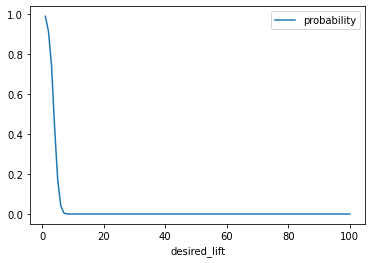

In [25]:
lines = result.plot.line(x='desired_lift', y='probability')

Advantages of Bayesian over Frequentist:
- Results are more interpretable than the ones we got from the frequentist approach
- We can interpret results at any point during the experiment.

## Decision
It is recommended to launching a change when the result is:
- Statistically significant (based on p-value, if Confidence interval overlaps with 0: NOT statistically significant)
- Practically significant (based on point estimate > practical significance boundary USD 2 / user)

If it is not the case, run a follow-up test with more power would be helpful in this case

- Tradeoffs between different metrics: If different metrics move in different directions, such as revenue and user engagment.
- Costs of launching: When costs are high, we need to make sure the benefit overwheigh the cost (using a practical significance boundary). When costs are low, any positive changes should be launched.


In [26]:
if proba >= power and p_value < alpha:
    print("- The test is statistically significant and practically significant")
    print(f"- Probability that we are seeing a {significant_lift}% lift is {proba}%")
    print("- The version should be launched")
elif proba < power and p_value < alpha:
    print("The test is statistically significant, but NOT practically significant")
elif proba >= power and p_value > alpha:
    print("The test is NOT statistically significant, but it is practically significant")
elif proba < power and p_value > alpha:
    print("The test is NOT statistically significant, and NOT practically significant")

- The test is statistically significant and practically significant
- Probability that we are seeing a 2% lift is 91.2%
- The version should be launched


# Post-Launch monitoring
Long-term effect:
- Different from short-term effect

# Note

If you want to randomly modify the nunmber of conversion in the treatment group for experiment, you can use this little piece of code:

In [27]:
# import random
# for row in df.itertuples():
#     r = random.randint(0,150)
#     if r == 1 and df.at[row.Index, "group"] == 'treatment':
#         df.at[row.Index, "converted"] = 1
# df.to_csv('data_modified.csv', index=False)